# 1. TensorFlow low-level concepts and functionality

In TF101 we mainly saw TensorFlow through the lens of Keras, its high-level API. We learned how we can define models, customize their architecture, train them and monitor their performance. However, we've seen very little of the actual library. Here we will attempt to dig a bit deeper into TensorFlow, expore its basic concepts and see how we can achieve an even higher degree of customization and flexibility.

In the first notebook will focus on the following topics:
1. Low-level TensorFlow operations.
2. Computational graphs. What are they and what do they have to do with TensorFlow?
3. Eager vs graph mode.
4. Automatic differentiation with AutoGrad.

In [29]:
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1. Low-level TensorFlow operations

TensorFlow can be more accurately described as a **symbolic math library**. This means that it essentially defines a series of data types and operations, through which we then define and train our Neural Networks. These are in the core of every one of TensorFlow's functionalities, including Keras.

### Basic data types

TensorFlow's basic data type is called a **tensor**. A [tensor](https://en.wikipedia.org/wiki/Tensor) in mathematics is essentially an object with more than $2$ dimensions. We've seen this concept before, but with a [different name](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.html). A tensor can have as many dimensions as we wish; One with $0$ dimensions can be called a scalar, with $1$ dimensions it is a vector and $2$ dimensions make it a matrix.

From a data structure point of view, TensorFlow's tensors are very much like numpy's ndarrays. The main differences are that tensors are much harder to work with, as they lack much of the functionality of numpy arrays (built-in methods, seamlessly working with core python functions, etc.) and the fact that they can be used for TensorFlow operations (where as numpy arrays can't).

There are two main tensor types, a Variable and a constant. The most important difference between the two are that the latter is immutable.

In [3]:
a = tf.constant([1, 2, 3, 4, 5])
b = tf.Variable([4, 5, 6, 7, 8])
print(a), print(b)

tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)
<tf.Variable 'Variable:0' shape=(5,) dtype=int32, numpy=array([4, 5, 6, 7, 8], dtype=int32)>


2023-04-15 20:18:58.081004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-15 20:18:58.081623: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-15 20:18:58.081694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (home): /proc/driver/nvidia/version does not exist
2023-04-15 20:18:58.085408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(None, None)

TensorFlow has its [own datatypes](https://www.tensorflow.org/api_docs/python/tf/dtypes), most of which should be very familiar. We can select the data type of any tensor duting instantiation.

In [4]:
a = tf.constant([1, 2, 3, 4, 5], dtype=tf.float32)
a

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 2., 3., 4., 5.], dtype=float32)>

It is also possible to change the dtype of a tensor by casting it to another. 

In [7]:
print(a.dtype)
a = tf.cast(a, tf.int64)
print(a.dtype)

<dtype: 'float32'>
<dtype: 'int64'>


Another way to create a tensor is to initialize it from an array or any other python iterable (list, typle, etc.).

In [8]:
arr = np.arange(9).reshape((3, 3))
t1 = tf.convert_to_tensor(arr)
t2 = tf.convert_to_tensor(arr.T)
t2

<tf.Tensor: shape=(3, 3), dtype=int64, numpy=
array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])>

Two other ways to initialize tensors are [`tf.zeros`](https://www.tensorflow.org/api_docs/python/tf/zeros) and [`tf.ones`](https://www.tensorflow.org/api_docs/python/tf/ones), which create tensors containing $0$s and $1$s respectively, with the given shape. These mimic [`numpy.zeros`](https://numpy.org/doc/1.18/reference/generated/numpy.zeros.html) and [`numpy.ones`](https://numpy.org/doc/1.18/reference/generated/numpy.ones.html).

In [9]:
z = tf.zeros((3, 4, 2), dtype=tf.float32)
z

<tf.Tensor: shape=(3, 4, 2), dtype=float32, numpy=
array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)>

### Basic arithmetic operations

Most common operations between tensors work with python's built-in operators. 

Note that all of these operations are performed **elementwise**.

In [10]:
print(t1 + t2)
print(t1 - t2)
print(t1 * t2)
print(t1 / t2)
print(t1 ** t2)

tf.Tensor(
[[ 0  4  8]
 [ 4  8 12]
 [ 8 12 16]], shape=(3, 3), dtype=int64)
tf.Tensor(
[[ 0 -2 -4]
 [ 2  0 -2]
 [ 4  2  0]], shape=(3, 3), dtype=int64)
tf.Tensor(
[[ 0  3 12]
 [ 3 16 35]
 [12 35 64]], shape=(3, 3), dtype=int64)
tf.Tensor(
[[       nan 0.33333333 0.33333333]
 [3.         1.         0.71428571]
 [3.         1.4        1.        ]], shape=(3, 3), dtype=float64)
tf.Tensor(
[[       1        1       64]
 [       3      256    78125]
 [      36    16807 16777216]], shape=(3, 3), dtype=int64)


Chaining operations is also possible.

In [11]:
r = (t1 - t2) ** 2
r

<tf.Tensor: shape=(3, 3), dtype=int64, numpy=
array([[ 0,  4, 16],
       [ 4,  0,  4],
       [16,  4,  0]])>

To convert a tensor to a numpy array we can just use their built-in mehtod `.numpy()`.

In [12]:
arr_r = r.numpy()
arr_r

array([[ 0,  4, 16],
       [ 4,  0,  4],
       [16,  4,  0]])

### Comparisons

As in all logical comparisons, the outcomes here are boolean variable. The comparisons themselves work like in numpy: **elementwise**. 

In [13]:
print('Equal:')
print(t1 == t2)

print('\nUnequal:')
print(t1 != t2)

print('\nGreater:')
print(t1 > t2)

print('\nLess:')
print(t1 < t2)

print('\nGreater or equal:')
print(t1 >= t2)

print('\nLess or equal:')
print(t1 <= t2)

Equal:
tf.Tensor(
[[ True False False]
 [False  True False]
 [False False  True]], shape=(3, 3), dtype=bool)

Unequal:
tf.Tensor(
[[False  True  True]
 [ True False  True]
 [ True  True False]], shape=(3, 3), dtype=bool)

Greater:
tf.Tensor(
[[False False False]
 [ True False False]
 [ True  True False]], shape=(3, 3), dtype=bool)

Less:
tf.Tensor(
[[False  True  True]
 [False False  True]
 [False False False]], shape=(3, 3), dtype=bool)

Greater or equal:
tf.Tensor(
[[ True False False]
 [ True  True False]
 [ True  True  True]], shape=(3, 3), dtype=bool)

Less or equal:
tf.Tensor(
[[ True  True  True]
 [False  True  True]
 [False False  True]], shape=(3, 3), dtype=bool)


### Random

[This module](https://www.tensorflow.org/api_docs/python/tf/random) is like [`numpy.random`](https://docs.scipy.org/doc/numpy-1.15.0/reference/routines.random.html), containing functions that involve randomness.

Most commonly we'll be sampling data from distributions: 


In [14]:
print(tf.random.uniform((4,)))  # draws samples from a uniform distribution

print(tf.random.normal((4,)))  # draws samples from a normal distribution

print(tf.random.truncated_normal((4,)))  # draws samples from a truncated normal distribution

tf.Tensor([0.30290473 0.09648383 0.5143337  0.24890459], shape=(4,), dtype=float32)
tf.Tensor([0.17572471 0.04610927 0.41917738 0.40969065], shape=(4,), dtype=float32)
tf.Tensor([-0.01369445 -0.87263983  0.8646996  -0.00374806], shape=(4,), dtype=float32)


Another important function is `tf.random.shuffle()`.

In [15]:
c = tf.constant([1, 2, 3, 4])
c = tf.random.shuffle(c)  # Note that unlike numpy's shuffle, this doens't change the 
                          # tensor inplace. Even if it worked that way the tensor
                          # is immutable, so we'd get an error. 
c

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([3, 4, 2, 1], dtype=int32)>

For repeatability, TensorFlow uses its own random seed. 

In [16]:
tf.random.set_seed(13)
print(tf.random.uniform((4,)))

tf.Tensor([0.5983684  0.07627809 0.34005308 0.9105623 ], shape=(4,), dtype=float32)


This works a bit stranger than expected, because TensorFlow generators keep their own counter so that they won't repeat the same numbers if they are called twice.  More details on how it works can be found in the [function's documentation](https://www.tensorflow.org/api_docs/python/tf/random/set_seed).

### Math operations

As we saw previously, the basic math operations between tensors (sum, prod, etc.) work with python's default operators (`+`, `*`, etc.). TensorFlow, offers a lot more in under the [`tensorflow.math`](https://www.tensorflow.org/api_docs/python/tf/math) module. Some examples are:

In [17]:
t = tf.convert_to_tensor(np.random.rand(16) * 10 - 5)

print('Absolute:')
print(tf.math.abs(t))

print('\nRound:')
print(tf.math.round(t))

print('\nCeiling:')
print(tf.math.ceil(t))

print('\nSign:')
print(tf.math.sign(t))

print('\nSquare root:')
print(tf.math.sqrt(t))

print('\nCount nonzero elements:')
c = tf.constant([0, 1, 1, 0, 0, 0, 1, 0, 1])
print(tf.math.count_nonzero(c))

print('\nNatural Logarithm:')
c = tf.constant([0, 1, 2, 3, 4], dtype=tf.float32)
print(tf.math.log(c))

Absolute:
tf.Tensor(
[2.07685151 0.7294304  0.48116864 0.35275976 2.91635089 2.47934768
 3.28349749 4.77447521 4.97510134 0.04599412 3.54395867 1.46371965
 3.16840568 3.80961972 3.17022757 2.89655164], shape=(16,), dtype=float64)

Round:
tf.Tensor([-2. -1. -0.  0. -3.  2. -3.  5. -5.  0. -4.  1. -3. -4.  3. -3.], shape=(16,), dtype=float64)

Ceiling:
tf.Tensor([-2. -0. -0.  1. -2.  3. -3.  5. -4.  1. -3.  2. -3. -3.  4. -2.], shape=(16,), dtype=float64)

Sign:
tf.Tensor([-1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.], shape=(16,), dtype=float64)

Square root:
tf.Tensor(
[       nan        nan        nan 0.59393582        nan 1.57459445
        nan 2.18505726        nan 0.21446239        nan 1.20984282
        nan        nan 1.78051329        nan], shape=(16,), dtype=float64)

Count nonzero elements:
tf.Tensor(4, shape=(), dtype=int64)

Natural Logarithm:
tf.Tensor([     -inf 0.        0.6931472 1.0986123 1.3862944], shape=(5,), dtype=float32)


#### Trigonometric functions

In [18]:
t = tf.constant([-0.5, 0, 0.5, 1, 1.5], dtype=tf.float32)
print('Original:')
print(t)

print('\nSine:')
print(tf.math.sin(t))

print('\nCosine:')
print(tf.math.cos(t))

print('\nTangent:')
print(tf.math.tan(t))

print('\nHyperbolic Sine:')
print(tf.math.sinh(t))

print('\nHyperbolic Cosine:')
print(tf.math.cosh(t))

print('\nHyperbolic Tangent:')
print(tf.math.tanh(t))

print('\nInverse Sine (arcsin):')
print(tf.math.asin(t))

print('\nInverse Cosine (arccos):')
print(tf.math.acos(t))

print('\nInverse Tangent (arctan):')
print(tf.math.atan(t))


Original:
tf.Tensor([-0.5  0.   0.5  1.   1.5], shape=(5,), dtype=float32)

Sine:
tf.Tensor([-0.47942555  0.          0.47942555  0.84147096  0.997495  ], shape=(5,), dtype=float32)

Cosine:
tf.Tensor([0.87758255 1.         0.87758255 0.5403023  0.0707372 ], shape=(5,), dtype=float32)

Tangent:
tf.Tensor([-0.5463025  0.         0.5463025  1.5574077 14.10142  ], shape=(5,), dtype=float32)

Hyperbolic Sine:
tf.Tensor([-0.5210953  0.         0.5210953  1.1752012  2.1292794], shape=(5,), dtype=float32)

Hyperbolic Cosine:
tf.Tensor([1.127626  1.        1.127626  1.5430806 2.3524096], shape=(5,), dtype=float32)

Hyperbolic Tangent:
tf.Tensor([-0.46211717  0.          0.46211717  0.7615942   0.9051482 ], shape=(5,), dtype=float32)

Inverse Sine (arcsin):
tf.Tensor([-0.5235988  0.         0.5235988  1.5707964        nan], shape=(5,), dtype=float32)

Inverse Cosine (arccos):
tf.Tensor([2.0943952 1.5707964 1.0471976 0.              nan], shape=(5,), dtype=float32)

Inverse Tangent (arctan):
tf.

#### Check for `nan` or `inf`

In [19]:
t = tf.convert_to_tensor(np.array([1, np.nan, 2, np.inf, 3, -np.inf, 4]))
print('Original:')
print(t)

print('\nIs finite?')
print(tf.math.is_finite(t))

print('\nIs nan?')
print(tf.math.is_nan(t))

print('\nIs infinite?')
print(tf.math.is_inf(t))

Original:
tf.Tensor([  1.  nan   2.  inf   3. -inf   4.], shape=(7,), dtype=float64)

Is finite?
tf.Tensor([ True False  True False  True False  True], shape=(7,), dtype=bool)

Is nan?
tf.Tensor([False  True False False False False False], shape=(7,), dtype=bool)

Is infinite?
tf.Tensor([False False False  True False  True False], shape=(7,), dtype=bool)


#### Reduce operations

All operations we've seen up till now are elementwise (i.e. they don't affect the dimensions of the input tensors).

Reduce opeations, on the other hand **reduce** the dimensions of their input. The most common example of a reduce operation is `max()`; this function takes $N$ items as its input and returns just $1$, i.e. the max.

In [20]:
print('Original:')
print(c)

print('\nMin:')
print(tf.math.reduce_min(c))

print('\nMax:')
print(tf.math.reduce_max(c))

print('\nMean:')
print(tf.math.reduce_mean(c))

print('\nSum:')
print(tf.math.reduce_sum(c))

print('\nProduct:')
print(tf.math.reduce_prod(c))

Original:
tf.Tensor([0. 1. 2. 3. 4.], shape=(5,), dtype=float32)

Min:
tf.Tensor(0.0, shape=(), dtype=float32)

Max:
tf.Tensor(4.0, shape=(), dtype=float32)

Mean:
tf.Tensor(2.0, shape=(), dtype=float32)

Sum:
tf.Tensor(10.0, shape=(), dtype=float32)

Product:
tf.Tensor(0.0, shape=(), dtype=float32)


Two other very useful reduce operations are `any` and `all`:

In [21]:
c1 = tf.constant([True, True, True, True])
c2 = tf.constant([True, False, False, False])
c3 = tf.constant([False, False, False, False])

print('c1:')
print(c1)
print('c2:')
print(c2)
print('c3:')
print(c3)

print('\nAny (c1, c2, c3):')
print(tf.math.reduce_any(c1))
print(tf.math.reduce_any(c2))
print(tf.math.reduce_any(c3))

print('\nAll (c1, c2, c3):')
print(tf.math.reduce_all(c1))
print(tf.math.reduce_all(c2))
print(tf.math.reduce_all(c3))

c1:
tf.Tensor([ True  True  True  True], shape=(4,), dtype=bool)
c2:
tf.Tensor([ True False False False], shape=(4,), dtype=bool)
c3:
tf.Tensor([False False False False], shape=(4,), dtype=bool)

Any (c1, c2, c3):
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)

All (c1, c2, c3):
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)


#### Segmentation Operations

These operations perform computations on tensor **segments**. The available operations are [min](https://www.tensorflow.org/api_docs/python/tf/math/segment_min), [max](https://www.tensorflow.org/api_docs/python/tf/math/segment_max), [mean](https://www.tensorflow.org/api_docs/python/tf/math/segment_mean), [sum](https://www.tensorflow.org/api_docs/python/tf/math/segment_sum) and [prod](https://www.tensorflow.org/api_docs/python/tf/math/segment_prod).

For example

```python
data = tf.constant([5, 1, 7, 2, 3, 4, 1, 3])
segmentation_ids = tf.constant([0, 0, 0, 1, 2, 2, 3, 3])
tf.math.segment_sum(data, segmentation_ids)
```
  
![](https://www.tensorflow.org/images/SegmentSum.png)

  
On N-dimensional tensors, the `segmentation_ids` correspond to the first dimension of the input tensor.

In [22]:
c = tf.constant([[1, 5, 3, 7], [4, 2, 8, 6], [-1, -5, -3, -7], [-2, -4, 0, -6]])
c

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 1,  5,  3,  7],
       [ 4,  2,  8,  6],
       [-1, -5, -3, -7],
       [-2, -4,  0, -6]], dtype=int32)>

From the tensor above we want to find the max element per column. However, we want to take into account the first two rows **separately** from last two (i.e. one max per column for rows 1 and 2 and one max per column for rows 3 and 4).

In [23]:
tf.math.segment_max(c, tf.constant([0, 0, 1, 1]))

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[ 4,  5,  8,  7],
       [-1, -4,  0, -6]], dtype=int32)>

Note that this operation essentially segments a tensor into some parts and efficiently performs a computation on each segment. These segments, however **need to be sorted** and cannot be shuffled (i.e. the second segment must start after the first has ended). For example an arrangement like this is invalid:

```python
tf.math.segment_max(c, tf.constant([0, 1, 0, 1]))
```

If we want the above we will have to use one of the **unsorted_segment** operations, namely:




In [24]:
tf.math.unsorted_segment_max(c, tf.constant([0, 1, 0, 1]), num_segments=2)  # the num_segments argument is necessary

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 5, 3, 7],
       [4, 2, 8, 6]], dtype=int32)>

#### Logical operations

The final category of functions we'll see are logical ones. These perform operations **between boolean values**.

In [25]:
b1 = tf.convert_to_tensor([True, False, True, False])
b2 = tf.convert_to_tensor([True, True, False, False])

print('B1:')
print(b1)

print('\nB2:')
print(b2)

print('\nB1 and B2:')
print(tf.math.logical_and(b1, b2))

print('\nB1 or B2:')
print(tf.math.logical_or(b1, b2))

print('\nnot B1:')
print(tf.math.logical_not(b1))

B1:
tf.Tensor([ True False  True False], shape=(4,), dtype=bool)

B2:
tf.Tensor([ True  True False False], shape=(4,), dtype=bool)

B1 and B2:
tf.Tensor([ True False False False], shape=(4,), dtype=bool)

B1 or B2:
tf.Tensor([ True  True  True False], shape=(4,), dtype=bool)

not B1:
tf.Tensor([False  True False  True], shape=(4,), dtype=bool)


### Linear Algebra

[`tensorflow.linalg`](https://www.tensorflow.org/api_docs/python/tf/linalg) is another module focucing on linear algebra operations. The most common of these are: 

In [26]:
r1 = tf.cast(r, dtype=tf.float32)

print('\nEigenvalue decomposition:')
e, v = tf.linalg.eig(r1)
print(e)  # eigenvalues
print(v)  # eigenvectors

print('\nMatrix Exponential:')
print(tf.linalg.expm(r1))

print('\nInverse:')
print(tf.linalg.inv(r1))

print('\nMatrix Norm (2nd order):')
print(tf.linalg.norm(r1))  # this has a parameter ord to control the order of the norm

print('\nTranspose:')
r2 = tf.linalg.matrix_transpose(r1)
print(r2)

print('\nMatrix multiplication:')
print(tf.linalg.matmul(r1, r2))


Eigenvalue decomposition:
tf.Tensor([ 17.797964 +0.j -16.000002 +0.j  -1.7979587+0.j], shape=(3,), dtype=complex64)
tf.Tensor(
[[-6.7388743e-01+0.j -7.0710695e-01+0.j  2.1418646e-01+0.j]
 [-3.0290544e-01+0.j -8.9203084e-08+0.j -9.5302063e-01+0.j]
 [-6.7388725e-01+0.j  7.0710665e-01+0.j  2.1418653e-01+0.j]], shape=(3, 3), dtype=complex64)

Matrix Exponential:
tf.Tensor(
[[24363040. 10950938. 24363042.]
 [10950937.  4922335. 10950939.]
 [24363040. 10950937. 24363042.]], shape=(3, 3), dtype=float32)

Inverse:
tf.Tensor(
[[-0.03125  0.125    0.03125]
 [ 0.125   -0.5      0.125  ]
 [ 0.03125  0.125   -0.03125]], shape=(3, 3), dtype=float32)

Matrix Norm (2nd order):
tf.Tensor(24.0, shape=(), dtype=float32)

Transpose:
tf.Tensor(
[[ 0.  4. 16.]
 [ 4.  0.  4.]
 [16.  4.  0.]], shape=(3, 3), dtype=float32)

Matrix multiplication:
tf.Tensor(
[[272.  64.  16.]
 [ 64.  32.  64.]
 [ 16.  64. 272.]], shape=(3, 3), dtype=float32)


### Important note on tensorflow modules:

The most common operations that are defined inside any of TensorFlow's modules have easily accessible aliases under `tensorflow`. 

For example, to compute the elementwise absolute values of a tensor `t` we can just write `tf.abs(t)` instead of `tf.math.abs(t)`.

It is important to note that these are **just aliases** and not different functions. This can be simply confirmed:

In [27]:
print(tf.abs is tf.math.abs)
print(tf.norm is tf.linalg.norm)

True
True


There has been a lot of effort made in TF2 to [clean up](https://www.tensorflow.org/guide/effective_tf2#api_cleanup) the `tensorflow` module, which was overbloated with aliases like these. For this reason I prefer using calling the functions from where they are defined and not their aliases (e.g. `tf.math.abs` instead of `tf.abs`). This, however, is simply a matter of preference.

## Part 2. Computational graph

If we have a sequence of operations, we can represent these as nodes in a graph. In this representation, the edges would be the tensors that flow from operation to operation.

For example, a fully connected layer that performs the operation:

$$
z = f(W \cdot X + b)
$$

This series of operations would be represented as a computational graph as follows.

![example computational graph](https://github.com/djib2011/tensorflow-training/blob/main/figures/comp_graph.png?raw=true)

In the figure above the boxes represent tensors (gray: input, pink: derived), while the circles represent operations. 

It wouldn't be hard to imagine how a whole Neural Network, along with its loss function would be represented in this fashion. Now we can picture an alternate training process, where we would first define the full computation graph and then run the actual computations.

An important detail we must understand, is that computation with this model actually happens in **two stages**:
1. the computational graph is constructed
2. the actual values are inputted and the computation actually happens$^1$

You can think this as a **lazy** approach to computation that is in contrast with the more **eager** way of computing that we're more familiar with. The differences might become more apparent if we look at this analogy in pure python: 

```python
# 1) Eagerly compute the result:
z = f(w * x + b)

# 2) Lazily compute the result:
def fc(x):
    return f(w * x + b)

# ... 
# at this point we have defined which operations
# we want to run, i.e. the "computation graph"
# ...

z = fc(x)  # run the actual computation
```

This computational model has several advantages over eagerly executing the operations.

- Computation graphs can be **simplified**. E.g. the operation `c = a + b - b` could be simplified into `c = a` even before we receive the actual values of `a` and `b`.

- We can add to each node two operation one for the **regular** path and one for the **reverse** path. This way our computation graph can be bidirectional. This is very useful for **backpropagation**, where we want the input tensors to flow in the forward path and the gradients in the backward path.

- We don't need to know the exact shape of the input when creating the graph. In practice this translates to **not** needing to specify the **batch size** when defining the model's architecture.

- There are several **optimization** tricks that TensorFlow can make to computation graphs, e.g. parallel processing.

It has its disadvantages also:

- **Complexity**. Imagine if you had to define a function every time you needed to do a simple addition in python!

- **Error Handling**. If we make a mistake when defining the graph, we'll know much later when actually running the graph.

$^1$ *An interesting thing to note is that this is where TensorFlow gets its name. We input the values to the computational graph and information **flows** through it as **tensors** to produce the final result.*

## Part 3. Eager vs graph mode

I know what you're thinking. TensorFlow has looked pretty eager until now. That's because it is, since version 2.0, **eager mode is the default in TensorFlow**. 

In [28]:
tf.executing_eagerly()

True

How do we utilize graph mode then?

Luckily, TensorFlow provides a tool to make our life easier: [AutoGraph](https://www.tensorflow.org/api_docs/python/tf/autograph). This is involked through the [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) decorator and converts any regular python syntax into a TensorFlow computation graph!

You can run the cell below twice for more accurate results.

In [34]:
# Regular keras FC layer
fc = tf.keras.layers.Dense(100)

# Same operation converted to a TensorFlow graph
@tf.function
def fc_graph(x):
    return fc(x)

# Create dummy data
X = tf.random.normal(shape=(1000, 100))

# Run each operation once for warmup
# (we have an initial "cost" of having to construct the graph, to evaluate which
# of the two is faster we need to take this out of the equation.)
fc(X); fc_graph(X)

# Run a forward pass on both keras and our tf-wrapped layer
t1 = time.time()
z1 = fc(X)
t2 = time.time()
z2 = fc_graph(X)
t3 = time.time()

# Assert that we performed the same operation and we got the same result
print('Same result:', np.array_equal(z1, z2))

# Print the results
print('Eager time: {:.2f}ms'.format((t2 - t1) * 1000))
print('Graph time: {:.2f}ms'.format((t3 - t2) * 1000))

Same result: True
Eager time: 1.07ms
Graph time: 1.18ms


This difference is bigger in other types of layers. The following example was taken from the [official TensorFlow guide on tf.functions](https://www.tensorflow.org/guide/function#the_tffunction_decorator). Remember to run this cell a couple of times.

In [37]:
# Keras LSTM layer
lstm_cell = tf.keras.layers.LSTMCell(10)

# Convert to tf Graph
@tf.function
def lstm_fn(input, state):
    return lstm_cell(input, state)

# Generate "dummy" input data
inp = tf.zeros([10, 10])
state = [tf.zeros([10, 10])] * 2

# Warmup
lstm_cell(inp, state); lstm_fn(inp, state)

# Run the benchmark
t1 = time.time()
z1 = lstm_cell(inp, state)
t2 = time.time()
z2 = lstm_fn(inp, state)
t3 = time.time()

print('Same result:', np.array_equal(z1, z2))

print('Eager time: {:.2f}ms'.format((t2 - t1) * 1000))
print('Graph time: {:.2f}ms'.format((t3 - t2) * 1000))

Same result: False
Eager time: 1.15ms
Graph time: 0.72ms


Here the forward pass takes up almost **half the time** when run in graph mode!

Some interesting details about the `tf.function` wrapper and graph mode in general are presented below. Some of these should concern only advanced users, I present them here mostly for reference:

- If we have a nested structure we just need to apply the decorator to the outer function. It will work on its own in the inner function as well. For example:

```python
# no need for @tf.function here
def a(x):
    return 2 * x

@tf.function
def b(x):
    return 3 * a(x)
```

- AutoGraph inhenetly handles any python control structures by converting the native python ops to TensorFlow graph ops. For example, python's `while` will become [`tf.while_loop`](https://www.tensorflow.org/api_docs/python/tf/while_loop), `if` will become [`tf.cond`](https://www.tensorflow.org/api_docs/python/tf/cond), etc.

- AutoGraph is enabled **by default** for all non-dynamic keras models.

- The first time a `tf.function` decorated function is involked, the AutoGraph module is called to construct the graph. This procedure is called [tracing](https://www.tensorflow.org/guide/function) and takes time. For this reason reason avoid applying `tf.function` to low-level local function; rather try to decorate module-level functions and class methods.  *Note: this is the reason we used a "warmup" when timing the execution before.*  A more in-depth analysis of this can be found [here](https://www.tensorflow.org/guide/function#re-tracing).

- Graphs were the "default view" of TensorFlow in versions `< 2.0`. TensorFlow still allows for the [direct (i.e. manual) construction of a graph](https://www.tensorflow.org/api_docs/python/tf/Graph#using_graphs_directly_deprecated). However, this approach is **deprecated** and should be avoided.

- Asynchronous batch prefetching (an important feature in data generators that we'll discuss in the 3rd notebook) is [only available](https://www.tensorflow.org/guide/effective_tf2#combine_tfdatadatasets_and_tffunction) when running in graph mode.

- Several **limitations** of AutoGraph (along with their workarounds) can be found [here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md). It is worthwile to go through them if you're planning to use the `tf.function` decorator.

- TensorFlow uses a tool called [Grappler](https://www.tensorflow.org/guide/graph_optimization) for **optimizing** its graphs. These optimizations include *pruning* redundant nodes, *stripping* debugging operations, *low-level memory mapping*, *parallelization* and many more. More info about these can be found [here](https://web.stanford.edu/class/cs245/slides/TFGraphOptimizationsStanford.pdf). Most of these are **enabled by default**, however Grappler also allows for a more [fine-grained control](https://www.tensorflow.org/api_docs/python/tf/config/optimizer/set_experimental_options).  

## Part 4. Automatic differentiation with AutoGrad

This part will focus on one of the key features of TensorFlow: automatic differentiation, i.e. the ability to compute the gradient of any operation. This is necessary for training Neural Networks. To accomplish this TensorFlow uses a technique called [reverse-mode automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

The main API we can use to compute the gradient of one or more operations is [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape). This defines a context, within which opeations are recorded. TensorFlow then uses auto-differentiation to compute the gradient of these operations w.r.t some tensor(s).

For example, suppose we have a function:

$$
f(x) = x^2 - 3x + 1
$$

and we want to compute its gradient w.r.t $x$, for $x = 2$:

$$
\frac{df}{dx}\bigg\rvert_{x=2}
$$

In [38]:
x = tf.Variable([2], dtype=tf.float32)

with tf.GradientTape() as tape:  # define a context, within which TensorFlow will record operations
    tape.watch(x)  # monitor the operations involving the tensor x
    f = x ** 2 - 3 * x + 1  # perform the operation inside the context

df = tape.gradient(f, x)  # compute the gradiend of f w.r.t x (i.e. df/dx)

print('f(2) =', f.numpy()[0])
print('df/dx for (x=2) is', df.numpy()[0])

f(2) = -1.0
df/dx for (x=2) is 1.0


As expected:

$$
\frac{df}{dx}\bigg\rvert_{x=2} = 2x - 3\rvert_{x=2} = 1
$$

TensorFlow watches all `tf.Variable`s by default so the `tape.watch(x)` commend was redundant before. Let's write it a bit better and do a few more computations.

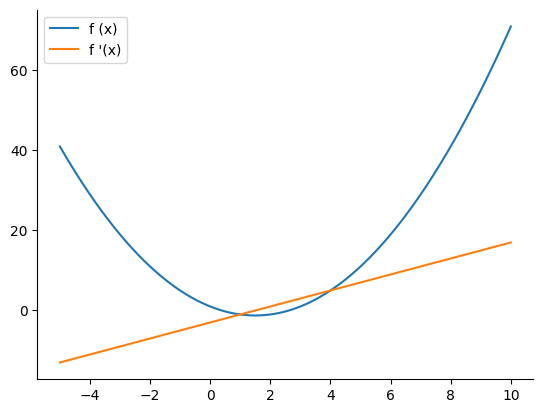

In [39]:
def f(x):
    return x ** 2 - 3 * x + 1

x2 = tf.Variable(np.linspace(-5, 10, 100), dtype=tf.float32)

with tf.GradientTape() as tape:
    y = f(x2) 

dy = tape.gradient(y, x2)


ax  = plt.subplot(111)
ax.plot(x2.numpy(), y.numpy(), label='f (x)')
ax.plot(x2.numpy(), dy.numpy(), label='f \'(x)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

If you want to disable this functionality and select specifically what `tf.GradientTape()` monitors, you can pass the argument `watch_accessed_variables=False` to its constructor. This can be useful when performing computations on large models, where you don't want to update some parameters.

In [40]:
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x)
    y = f(x)
    y2 = f(x2)  # not being recorded

print('dy2/dx2 =', tape.gradient(y2, x2))

dy2/dx2 = None


This can be useful for saving memory, as no resources were allocated to store the operations involving `x2`.

Explicitly telling `tf.GradientTape` what to watch requires a bit of caution because we need to make sure that the variable exists when we call `.watch()`. There are some scenarios where this might be tricky. One such example can be found at the `tf.GradientTape`'s [documentation page](https://www.tensorflow.org/api_docs/python/tf/GradientTape).

`tf.GradientTape` holds its resources, by default, **only** until the `.gradient()` method is called. 

In [41]:
with tf.GradientTape() as tape:
    f = x ** 2 - 3 * x + 1

df = tape.gradient(f, x)
df = tape.gradient(f, x)  # won't work

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

To create a persistent tape, whose `.gradient()` method can be called multiple times, pass the argument `persistent=True` to the tape.

In [42]:
with tf.GradientTape(persistent=True) as tape:
    f = x ** 2 - 3 * x + 1

df = tape.gradient(f, x)
df = tape.gradient(f, x)

To release the resources just drop all references to the tape so that it can be garbage collected.

In [43]:
del tape

`tf.GradientTape` handles Python's control flow naturally. This can be confirmed through a few examples.  

In [44]:
# Loops
with tf.GradientTape(persistent=True) as tape:
    y1 = x * x * x * x * x   # x ** 5

    y2 = 1
    for _ in range(5):
        y2 *= x              # same thing calculated iteratively in a for loop
  
    i = 0
    y3 = 1
    while i < 5:
        y3 *= x              # same thing in a while loop
        i += 1

# Check if the 3 gradients are the same
assert tape.gradient(y1, x) == tape.gradient(y2, x)
assert tape.gradient(y1, x) == tape.gradient(y3, x)

# Conditions
with tf.GradientTape() as tape2:
    y4 = 1
    for i in range(10):
        if i % 2:
            y4 *= x  # only multiply for odd i's

# We have 5 odd i's in the range [0, 9] (i.e. 1, 3, 5, 7, 9), so we expect
# y4 = x * x * x * x * x. This means that y4 should be the same as y1
assert tape.gradient(y1, x) == tape2.gradient(y4, x)

# Recursion
def rec(x, y=1, i=0):
    '''
    A dumb recursion that multiplies x with itself 5 times.
    '''
    if i < 5:
        return rec(x, y*x, i+1)
    else:
        return y

with tf.GradientTape() as tape3:
    y5 = rec(x)

# Since the recursion essentially did y5 = x * x * x * x * x, y5's gradient
# should be the same as y1's.
assert tape.gradient(y1, x) == tape3.gradient(y5, x)

print('All cleared!')

All cleared!


Another feature of `tf.GradientTape` is that it can record the computation of gradients. This means that if we nest two tape contexts and record the inner context's `.gradient()` we can compute **higher-order gradients**!

We'll use the function 

$$
f(x) = 5x^3 - 4x^2 + 2x - 3 \\
\frac{df}{dx} = 15x^2 - 8x + 2 \\
\frac{d^2f}{dx} = 30x - 8
$$

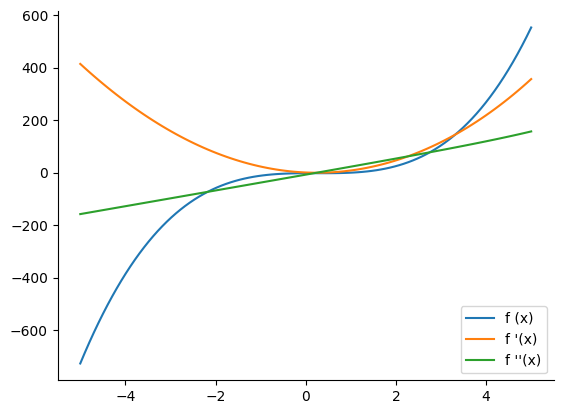

In [45]:
def f(x):
    return 5 * x ** 3 - 4 * x ** 2 + 2 ** x - 3

x2 = tf.Variable(np.linspace(-5, 5, 100), dtype=tf.float32)

with tf.GradientTape() as outer_tape:

    with tf.GradientTape() as inner_tape:

        y = f(x2)

    dy = inner_tape.gradient(y, x2)  # compute the first-order derivative of y w.r.t x

d2y = outer_tape.gradient(dy, x2)  # compute the second-order derivative of y w.r.t x

ax  = plt.subplot(111)
ax.plot(x2.numpy(), y.numpy(), label='f (x)')
ax.plot(x2.numpy(), dy.numpy(), label='f \'(x)')
ax.plot(x2.numpy(), d2y.numpy(), label='f \'\'(x)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

Another thing to keep in mind is that we can stop the recording of operations inside the context of a `tf.GradientTape()` with the `.stop_recording()` method, which is used as its own context.

```python
with tf.GradientTape() as tape:
    y1 = f1(x)
    with tape.stop_recording():
        y2 = f2(x)  # this operation is not recorded
    y3 = f3(x)
```

This can be useful to save memory.